# Import Required packages for the analysis

In [59]:
import sys
!{sys.executable} -m pip install pandasql
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# By Defaults pandas shows only 20 columns, so we will set the max columns display to None
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
from pandasql import sqldf

# Import data

* Import the data from below url

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
    

In [258]:
_file = 'bank-additional-full.csv'
# read csv file and drop duplicates
df_bank = pd.read_csv(_file, 'Bank_data', delimiter=';').drop_duplicates() 
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


* Check the datatypes of the fields

In [259]:
print(df_bank.dtypes)

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


* Look at the class (subscribed vs not subscribed) ratio in the data

In [260]:

print(sqldf("select count(*)as count_of_rows,y as subscribe_term_deposit from df_bank group by y"))


   count_of_rows subscribe_term_deposit
0          36537                     no
1           4639                    yes


There is a definite class imbalance, suggesting that any prediction model will learn way too much about program success than about program failure.It will be required to oversample the minority class or undersample the majority class.

Considering to spend about 2 hours on this task, I will limit my work to data anlysis limited to client data only, that is age, job, marital, education, defualt, housing and loan.

In [261]:
df_bank= df_bank[['age','job','marital','education','default','housing','loan','y']]

# Exploring Client Data
## 1. Age

Lets look at the distribution of current capaign by age.

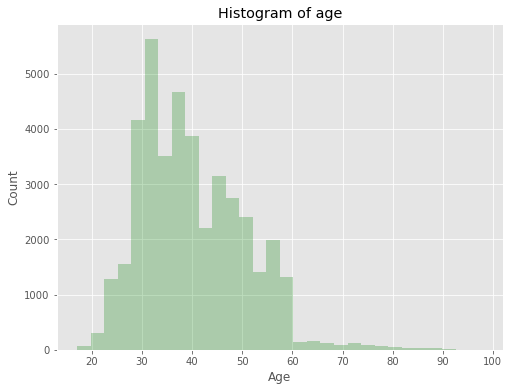

In [262]:
plt.figure(figsize=(8,6))
plt.hist(df_bank['age'],label='Yes',alpha=0.25, color='g',bins=30)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of age')
plt.show()

* As we can see, most data is between the age of 30 to 40, followed by 40 to 50.
* To help our analysis, I will bin the age to age groups

In [263]:
bins = [10,25,35,45,60,100]
df_bank['agebins'] = pd.cut(df_bank['age'], bins, labels=['10+','25+','35+','45+','60+'])


* Let's get percentage of subscribed to total outreach of the campaign.

In [264]:
df_agebins=df_bank[['agebins','y']]
df_agebins_yes= df_agebins[df_agebins['y']=='yes'].groupby('agebins').count()
df_agebins_no= df_agebins[df_agebins['y']=='no'].groupby('agebins').count()
df_agebins= df_agebins_yes.join(df_agebins_no, on='agebins', how='left', lsuffix='_subscribed', rsuffix='_not_subscribed', sort=False)
df_agebins['total']=df_agebins['y_subscribed']+df_agebins['y_not_subscribed']
df_agebins['pct_subscribed']=df_agebins['y_subscribed']*100/df_agebins['total']
df_agebins=df_agebins.reset_index()
df_agebins

,agebins,y_subscribed,y_not_subscribed,total,pct_subscribed
0,10+,349,1316,1665,20.960961
1,25+,1740,13104,14844,11.721908
2,35+,1092,11747,12839,8.505335
3,45+,1044,9875,10919,9.561315
4,60+,414,495,909,45.544554


* Visualize the percentage of successful subscription to the term deposit vs total contacts for each age group

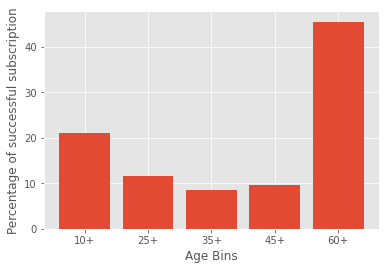

In [265]:
plt.ylabel('Percentage of successful subscription')
plt.xlabel('Age Bins')
plt.bar(df_agebins.agebins,df_agebins.pct_subscribed)
plt.show()

#### Observations from age feature

* Although age groups 25+, 35+ and 45+ are contacted more, we see more positive result from 60+
* Law of large number ( larger sample gives result closer to actual/true result) could also be implied from here.
* It will be interesting to see if the ratio of poisitive response stays closer for 65+ age group if they are contacted more.

Lets do similar analysis on remaining features:

## 2. Job

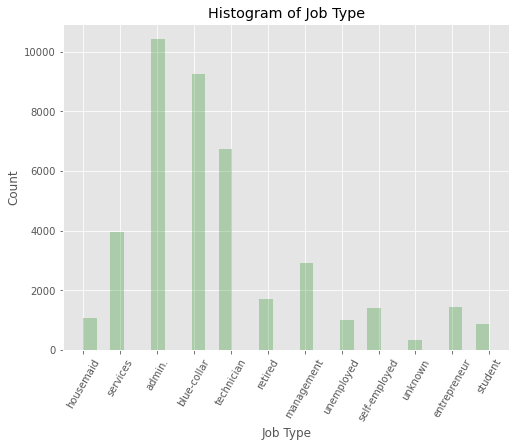

In [266]:
# Histogram of total contacts by job type
plt.figure(figsize=(8,6))
plt.hist(df_bank['job'],label='Yes',alpha=0.25, color='g',bins=30)
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.title('Histogram of Job Type')
plt.show()

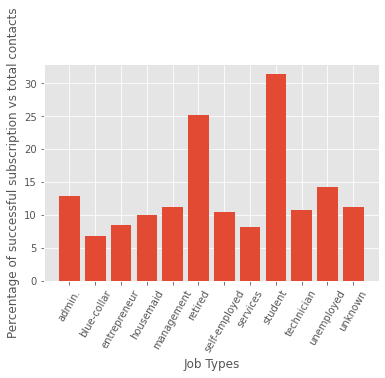

In [267]:
# Get pct of successful subscription vs total contacts by job type
df_job=df_bank[['job','y']]
df_job_yes= df_job[df_job['y']=='yes'].groupby('job').count()
df_job_no= df_job[df_job['y']=='no'].groupby('job').count()
df_job= df_job_yes.join(df_job_no, on='job', how='left', lsuffix='_yes', rsuffix='_no', sort=False)
df_job['total']=df_job['y_yes']+df_job['y_no']
df_job['pct']=df_job['y_yes']*100/df_job['total']
df_job=df_job.reset_index()

plt.ylabel('Percentage of successful subscription vs total contacts')
plt.xlabel('Job Types')
plt.bar(df_job.job,df_job.pct)
plt.xticks(rotation=60)
plt.show()


* Although employed people specially blue-collar,admin and technicians are contacted the most, we see a greater percetage of positive response from people like student and retirees who dont have a daily job but may have funds to subscribe to the term deposit.
* This could be because such people may have time to know and research about the program better, or the current campaign appeals more to folks who dont have a daily jobs but have a regular source of funds or income.

## 3. Marital Status

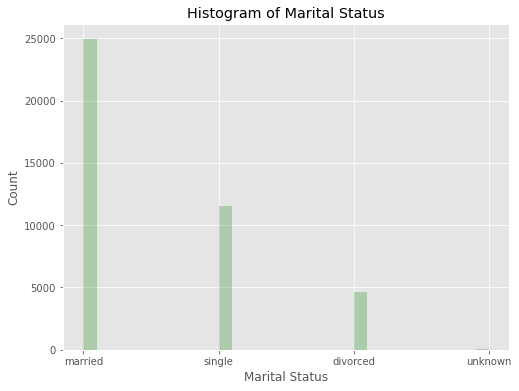

In [268]:
# Histogram of total contacts by marital status
plt.figure(figsize=(8,6))
plt.hist(df_bank['marital'],label='Yes',alpha=0.25, color='g',bins=30)
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Histogram of Marital Status')
plt.show()

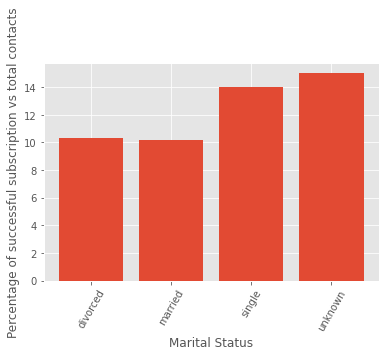

In [269]:
df_marital=df_bank[['marital','y']]
df_marital_yes= df_marital[df_marital['y']=='yes'].groupby('marital').count()
df_marital_no= df_marital[df_marital['y']=='no'].groupby('marital').count()
df_marital= df_marital_yes.join(df_marital_no, on='marital', how='left', lsuffix='_yes', rsuffix='_no', sort=False)
df_marital['total']=df_marital['y_yes']+df_marital['y_no']
df_marital['pct']=df_marital['y_yes']*100/df_marital['total']
df_marital=df_marital.reset_index()

plt.ylabel('Percentage of successful subscription vs total contacts')
plt.xlabel('Marital Status')
plt.bar(df_marital.marital,df_marital.pct)
plt.xticks(rotation=60)
plt.show()

* Although married contacts are significatly higher,there is not a great variation in the positive result vs contacts made to each of the group.

## 4. Education

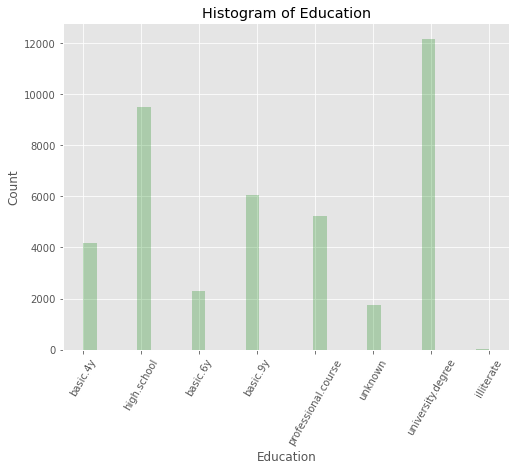

In [270]:
# Histogram of total contacts by education
plt.figure(figsize=(8,6))
plt.hist(df_bank['education'],label='Yes',alpha=0.25, color='g',bins=30)
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.title('Histogram of Education')
plt.show()

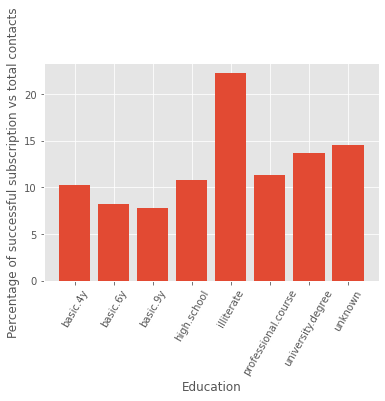

In [271]:
df_edu=df_bank[['education','y']]
df_edu_yes= df_edu[df_edu['y']=='yes'].groupby('education').count()
df_edu_no= df_edu[df_edu['y']=='no'].groupby('education').count()
df_edu= df_edu_yes.join(df_edu_no, on='education', how='left', lsuffix='_yes', rsuffix='_no', sort=False)
df_edu['total']=df_edu['y_yes']+df_edu['y_no']
df_edu['pct']=df_edu['y_yes']*100/df_edu['total']
df_edu=df_edu.reset_index()

plt.ylabel('Percentage of successful subscription vs total contacts')
plt.xlabel('Education')
plt.bar(df_edu.education,df_edu.pct)
plt.xticks(rotation=60)
plt.show()

* We see great percetage of positive response from illiterate folks although they are contacted the least

## 5. Credit Default, Housing Loan and Personal Loan

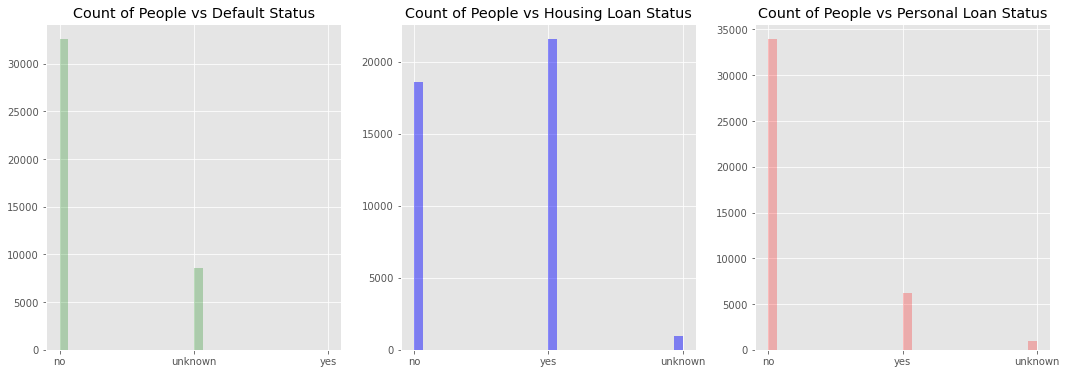

In [272]:
# Histogram of total contacts by credit default, housing loan and personal loan
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,6))

ax1.hist(df_bank['default'],label='Yes',alpha=0.25, color='g',bins=30)
ax1.set_title('Count of People vs Default Status')

ax2.hist(df_bank['housing'],label='Yes',alpha=0.45, color='b',bins=30)
ax2.set_title('Count of People vs Housing Loan Status')

ax3.hist(df_bank['loan'],label='Yes',alpha=0.25, color='r',bins=30)
ax3.set_title('Count of People vs Personal Loan Status')


plt.show()

* There are hardly any defaults, hence we can ignore this feature and assume all to have no default.
* Distribution of people with and without housing loan is almost similar.
* Most people contacted dont have personal loan

## Create people profile based on above observations

* To dig deeper, i will create profile of people based on their age group, job type, marital status, education, hosuing loan status and personal loan status.
* I am ignoring credict default status since most people are not defaulted or unknown

In [275]:
# create new feature client profile
df_bank['Client_profile'] = df_bank[['agebins','job','marital','education','housing','loan']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

# get percetage of positive response and total contacts for all profile types
df_profile=df_bank[['Client_profile','y']]
df_profile_yes= df_profile[df_profile['y']=='yes'].groupby('Client_profile').count()
df_profile_no= df_profile[df_profile['y']=='no'].groupby('Client_profile').count()
df_profile= df_profile_yes.join(df_profile_no, on='Client_profile', how='left', lsuffix='_subscribed', rsuffix='_not_subscribed', sort=False).fillna(0)
df_profile['total']=df_profile['y_subscribed']+df_profile['y_not_subscribed']
df_profile['pct_subscribed']=df_profile['y_subscribed']*100/df_profile['total']
df_profile=df_profile.reset_index()
df_profile

,Client_profile,y_subscribed,y_not_subscribed,total,pct_subscribed
0,10+_admin._married_basic.9y_yes_no,3,0.0,3.0,100.000000
1,10+_admin._married_university.degree_no_no,1,5.0,6.0,16.666667
2,10+_admin._married_university.degree_unknown_u...,1,0.0,1.0,100.000000
3,10+_admin._married_university.degree_yes_no,1,12.0,13.0,7.692308
4,10+_admin._married_unknown_no_no,2,3.0,5.0,40.000000
...,...,...,...,...,...
1130,60+_unemployed_single_basic.4y_yes_no,1,1.0,2.0,50.000000
1131,60+_unknown_divorced_unknown_yes_no,3,1.0,4.0,75.000000
1132,60+_unknown_married_unknown_no_no,1,2.0,3.0,33.333333
1133,60+_unknown_married_unknown_yes_no,3,2.0,5.0,60.000000


## Pareto Analysis
* It will be intertesting to see that which profiles type have a great potential of good subscription rate but dont look significat due to lesser contacts.
* Findings of such profiles will be useful in re-designing outreach to such profiles in next campaign.
* I will use pareto analysis 80-20 rule to categorize vital few and trivial many profiles.
* I will compare the profiles that are vital few based on subscription rate but trivial many based on contacts.



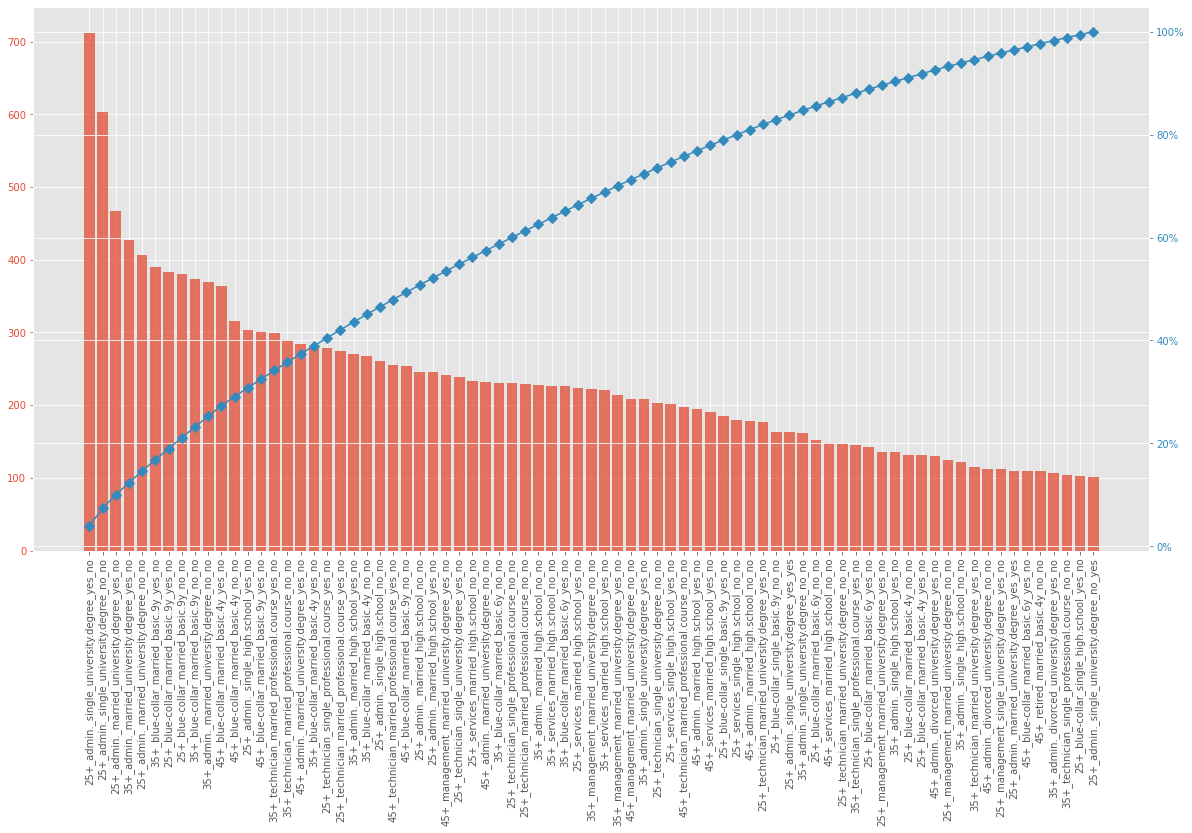

In [276]:
# pareto analysis on the profiles vs number of contacts
from matplotlib.ticker import PercentFormatter

# exclude the profiles that have less than 100 contacts
df_profile= df_profile[df_profile["total"]>100]
df_profile = df_profile.sort_values(by='total',ascending=False)
df_profile["cumpercentage"] = df_profile["total"].cumsum()/df_profile["total"].sum()*100
fig, ax =plt.subplots(figsize=(20,10))
ax.bar(df_profile.Client_profile, df_profile["total"], color="C0",alpha=0.75)
ax2 = ax.twinx()
ax2.plot(df_profile.Client_profile, df_profile["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.show()

* Above contains bars for each profile type and a line graph based on cumulative percetage of the profiles from left to right.
* The count of contacts for individual profile are represented in descending order by bars, and the cumulative total is represented by the line. 
* The all the profiles to the left of the profile that traces the 80% are vital few which explains most of the contacts in our data.

Below are the list of profiles that are trivial many, which are not significant enough

In [277]:
df_profile_20= df_profile[df_profile["cumpercentage"]>=80.0]
df_profile_20

,Client_profile,y_subscribed,y_not_subscribed,total,pct_subscribed,cumpercentage
757,45+_admin._married_high.school_no_no,16,162.0,178.0,8.988764,80.974543
374,25+_technician_married_university.degree_yes_no,15,162.0,177.0,8.474576,81.967029
192,25+_blue-collar_single_basic.9y_no_no,14,149.0,163.0,8.588957,82.881014
152,25+_admin._single_university.degree_yes_yes,19,144.0,163.0,11.656442,83.794998
472,35+_admin._single_university.degree_no_no,15,146.0,161.0,9.316770,84.697768
167,25+_blue-collar_married_basic.6y_no_no,11,141.0,152.0,7.236842,85.550073
953,45+_services_married_high.school_no_no,6,142.0,148.0,4.054054,86.379948
371,25+_technician_married_university.degree_no_no,9,138.0,147.0,6.122449,87.204217
698,35+_technician_single_professional.course_yes_no,12,133.0,145.0,8.275862,88.017270
170,25+_blue-collar_married_basic.6y_yes_no,12,131.0,143.0,8.391608,88.819110


Now lets compare the postive reponse rate for each profile in a pareto chart

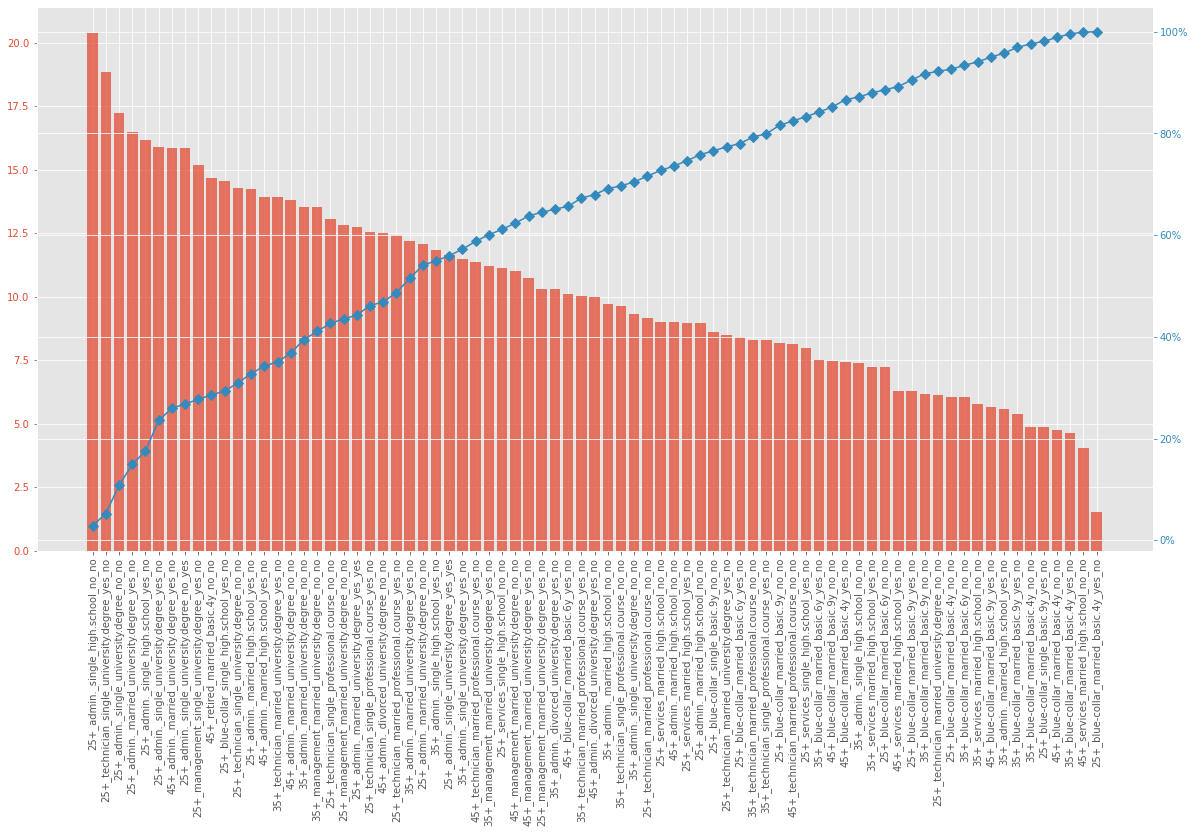

In [280]:
from matplotlib.ticker import PercentFormatter


df_profile = df_profile.sort_values(by='pct_subscribed',ascending=False)
df_profile["cumpercentage"] = df_profile["y_subscribed"].cumsum()/df_profile["y_subscribed"].sum()*100
fig, ax =plt.subplots(figsize=(20,10))
ax.bar(df_profile.Client_profile, df_profile["pct_subscribed"], color="C0",alpha=0.75)
ax2 = ax.twinx()
ax2.plot(df_profile.Client_profile, df_profile["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.show()

Lets look at the vital few of the subscription rate and see which profiles from trivial many from contacts overlap.

In [282]:
# get the vital few from subscription rate
df_profile_80= df_profile[df_profile["cumpercentage"]<80.0]

# compare by joining on the profiles that are vital few in subscription rate but trivial many in contacts
overlap = df_profile_20.merge(df_profile_80, on='Client_profile', how='inner', suffixes =('_contact', '_positive'))
overlap



,Client_profile,y_subscribed_contact,y_not_subscribed_contact,total_contact,pct_subscribed_contact,cumpercentage_contact,y_subscribed_positive,y_not_subscribed_positive,total_positive,pct_subscribed_positive,cumpercentage_positive
0,45+_admin._married_high.school_no_no,16,162.0,178.0,8.988764,80.974543,16,162.0,178.0,8.988764,73.571810
1,25+_technician_married_university.degree_yes_no,15,162.0,177.0,8.474576,81.967029,15,162.0,177.0,8.474576,77.362520
2,25+_blue-collar_single_basic.9y_no_no,14,149.0,163.0,8.588957,82.881014,14,149.0,163.0,8.588957,76.561666
3,25+_admin._single_university.degree_yes_yes,19,144.0,163.0,11.656442,83.794998,19,144.0,163.0,11.656442,55.953017
4,35+_admin._single_university.degree_no_no,15,146.0,161.0,9.316770,84.697768,15,146.0,161.0,9.316770,70.475174
5,35+_technician_single_professional.course_yes_no,12,133.0,145.0,8.275862,88.017270,12,133.0,145.0,8.275862,79.925254
6,25+_blue-collar_married_basic.6y_yes_no,12,131.0,143.0,8.391608,88.819110,12,131.0,143.0,8.391608,78.003203
7,25+_management_married_university.degree_yes_no,14,122.0,136.0,10.294118,89.581698,14,122.0,136.0,10.294118,64.495462
8,35+_admin._single_high.school_yes_no,16,119.0,135.0,11.851852,90.338679,16,119.0,135.0,11.851852,54.938601
9,45+_admin._divorced_university.degree_yes_no,13,117.0,130.0,10.000000,92.547942,13,117.0,130.0,10.000000,67.965830


## Findings:

* The above profiles are the ones that are contacted less but have shown significat subscription rate.
* Better outreach to these profiles have high chances of more subscription rate.

# Other analysis considerations

If time would have permitted, below are few other things that I would have added to the analysis:
    * Coorelation of previous campaign outcome on current campaign subscription rate
    * Seasonality effect on the subscription rate        
    * economy impact on the subscription rate
    